# Metabolite Figures

In this jupyter notebook, I will run statistical analysus for each of 4 metabolites among the 4 diet groups. The 4 metabolites will be: 
1. Adiponectin
2. Leptin
3. Triglyceride
4. Liver Weight  <font color=red>Replaced Cholesterol</font> 

I will perform statistical analysis of each of the metabolite levels to see which diet group significantly differed from another diet group. I will run 3 tests:
1. 2-sample independent t-test
2. ANOVA
3. MannU Whitney Analysis

In [1]:
#----------------------------------------------------------
# Import important libraries
#----------------------------------------------------------
import pandas  as pd
import numpy   as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp
sns.set()

In [2]:
#----------------------------------------------------------
# Method to run Anova
#----------------------------------------------------------
def anova_analysis(metabolite, anova_data):
    formula = metabolite + ' ~ C(diet) + C(feeding_schedule) + C(diet):C(feeding_schedule)'
    model = ols(formula, anova_data).fit()
    aov_table = anova_lm(model, typ=1)
    return aov_table

## Importing Metabolite and Hormonal Master Data Document

In [3]:
#----------------------------------------------------------
# Collect all the relevant data from the .xlxs file into one 'master_data' dataframe
#----------------------------------------------------------
master_data_location = 'https://www.dropbox.com/s/eu0szifsb9yimo3/2018VT_termination_data_master_document.csv?dl=1'
master_data = pd.read_csv(master_data_location)
master_data['group']=master_data.diet+' '+master_data.feeding_schedule
master_data = master_data.set_index('group')
master_data['diet-schedule']=master_data.diet+' '+master_data.feeding_schedule
master_data = master_data.rename(columns={" Leptin": "Leptin", "triglyceride (mg/mL)": "Triglyceride"}, index = {"control ad lib": "Control Ad Lib", "control restriction": "Control Restricted", "HFHS ad lib": "HFHS Ad Lib", "HFHS restriction": "HFHS Restricted"})

#----------------------------------------------------------
# Collect all the relevant data from the .xlxs file into one 'master_data' dataframe
#----------------------------------------------------------
anova_data = pd.read_csv(master_data_location, index_col=0)
anova_data = anova_data.rename(columns={" Leptin": "Leptin", "triglyceride (mg/mL)": "Triglyceride"})
anova_data['diet_and_schedule'] = anova_data["diet"].astype(str) +" "+ anova_data["feeding_schedule"].astype(str)
anova_data.head()


,diet,feeding_schedule,liver_weight,total_abdominal_fat,total_gonadal_fat,total_fat_pad,final_BW,Leptin,Cholesterol,Triglyceride,GSP (umol/L),Adiponectin,diet_and_schedule
Rat,,,,,,,,,,,,,
1,control,ad lib,17.2,4.6,3.9,8.5,380,1.637628,82.053143,0.942691,112.240742,4.988413,control ad lib
2,control,ad lib,14.0,5.4,3.4,8.8,318,2.032943,103.345415,1.254153,121.759269,4.256736,control ad lib
3,control,ad lib,13.6,5.5,3.5,9.0,351,1.555637,55.869566,0.228261,144.648151,6.666516,control ad lib
4,control,ad lib,14.5,5.2,4.7,9.9,357,2.997072,96.807567,0.407609,155.222252,3.853354,control ad lib
5,control,ad lib,13.5,7.4,5.6,13.0,363,2.704246,81.771341,0.619565,221.916665,4.382227,control ad lib


# 1. 2-sample indepdentent t-test

I will use Student's t-test (default version in stats) to compare metabolite levels between diet groups

In [4]:
metabolites_hormones = ['Leptin', 'Adiponectin', 'Triglyceride', 'liver_weight']

t_test_results = {}
for group in metabolites_hormones:
    group1 = anova_data.where(anova_data.diet_and_schedule == "control ad lib")[group].dropna()
    group2 = anova_data.where(anova_data.diet_and_schedule == "control restriction")[group].dropna()
    group3 = anova_data.where(anova_data.diet_and_schedule == "HFHS ad lib")[group].dropna()
    group4 = anova_data.where(anova_data.diet_and_schedule == "HFHS restriction")[group].dropna()
    # Control AdLib vs Control Restricted
    t_test_results[group + "- Control AdLib vs Control Restricted"] = stats.ttest_ind(group1,group2)
    # Control Adlib vs HFHS Ad Lib
    t_test_results[group + "- Control Adlib vs HFHS Ad Lib"] = stats.ttest_ind(group1,group3)
    # HFHS AdLib vs HFHS Restricted
    t_test_results[group + "- HFHS AdLib vs HFHS Restricted"] = stats.ttest_ind(group3,group4)
    # Control Restricted vs HFHS Restricted
    t_test_results[group + "- Control Restricted vs HFHS Restricted"] = stats.ttest_ind(group2,group4)
results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df.columns = ['statistic','pvalue']
#results_df
significant_group_v2 = results_df[results_df.pvalue<0.05].drop_duplicates(subset='pvalue')
significant_group_v2

,statistic,pvalue
Leptin- HFHS AdLib vs HFHS Restricted,3.969400,0.001234
Adiponectin- Control AdLib vs Control Restricted,-4.614599,0.000287
Adiponectin- Control Adlib vs HFHS Ad Lib,-2.159933,0.047374
Adiponectin- Control Restricted vs HFHS Restricted,3.153935,0.006144
Triglyceride- Control Adlib vs HFHS Ad Lib,-4.964125,0.000170
Triglyceride- HFHS AdLib vs HFHS Restricted,2.381855,0.030901
Triglyceride- Control Restricted vs HFHS Restricted,-2.963942,0.009141


## 2. ANOVA STATISTICS

### First, I'll check for normality with the Shapiro-Wilk Test

In [5]:
for level in metabolites_hormones:
    for group in master_data["diet-schedule"].unique():
        w, p = stats.shapiro(master_data.where(master_data["diet-schedule"] == group)[level].dropna())
        if p < 0.05:
            print(group)
            print(level)
            print(p)

control ad lib
Adiponectin
0.03896492347121239
control restriction
Adiponectin
0.045302849262952805
HFHS restriction
Triglyceride
0.04798966273665428
HFHS ad lib
liver_weight
0.001900134258903563


### Next, I'll check for equal variance with the Levene Test

In [6]:
for level in metabolites_hormones:
    
    variances = {}
    
    for group in master_data["diet-schedule"].unique():
        variances[str(group)] = np.var(master_data.where(master_data["diet-schedule"] == group)[level].dropna())

    control_ad_lib_level = master_data.where(master_data["diet-schedule"] == "control ad lib")[level].dropna()
    control_restriction_level = master_data.where(master_data["diet-schedule"] == "control restriction")[level].dropna()
    HFHS_ad_lib_level = master_data.where(master_data["diet-schedule"] == "HFHS ad lib")[level].dropna()
    HFHS_restriction_level = master_data.where(master_data["diet-schedule"] == "HFHS restriction")[level].dropna()

    s, p = stats.levene(control_ad_lib_level, control_restriction_level, HFHS_ad_lib_level, HFHS_restriction_level)
    if p < 0.05:
        print(level)
        print(p)
        print(variances)

Triglyceride
0.039568827050848826
{'control ad lib': 0.13555148700425432, 'control restriction': 0.07353397763078243, 'HFHS ad lib': 1.7203411798598836, 'HFHS restriction': 0.883150351629787}


In the future, I'll try running ANOVA with log-transformed data for Triglycerides

### Now, I will Run an ANOVA Analysis

In [7]:
#----------------------------------------------------------
# Run ANOVA stats
#----------------------------------------------------------
metabolites_hormones = ['Leptin', 'Adiponectin', 'Triglyceride', 'liver_weight']

for group in metabolites_hormones:
    anova_df = anova_analysis(group, anova_data)

    # Tukey post-hoc
    mc_interaction = statsmodels.stats.multicomp.MultiComparison(anova_data[group], anova_data['diet_and_schedule'])
    # The problem with .tukeyhsd (or pairwise_tukeyhsd) in python or statsmodels is that the p-adj values are bound by 0.001 or 0.9 so exact values 
    #outside these intervals cannot be given - exact values can be calculated in R with aov() with factored groups and TukeyHSD(). But for our data,
    # I don't think it's a problem since we can just set alpha = 0.001 and check if the "reject" value is True or False
    mc_interaction_results = mc_interaction.tukeyhsd(alpha = 0.05)
    mc_interaction = pd.DataFrame(data=mc_interaction_results._results_table.data[1:], columns=mc_interaction_results._results_table.data[0])
    
    print(group)
    
    result = pd.concat([anova_df, mc_interaction], axis = 0, sort = False)
    result.to_csv(group + "_statistical_analysis.csv")
    if result["reject"].sum() > 0:
        print(result.loc[[0, 1, 4, 5], ["group1", "group2", "p-adj", "reject"]].to_string(index = False))
        print(result.iloc[0:3, 0:5])
    

Leptin
           group1               group2   p-adj reject
      HFHS ad lib     HFHS restriction  0.0010   True
      HFHS ad lib       control ad lib  0.0627  False
 HFHS restriction  control restriction  0.9000  False
   control ad lib  control restriction  0.3947  False
                              df     sum_sq    mean_sq          F    PR(>F)
C(diet)                      1.0   1.144797   1.144797   2.069572  0.160284
C(feeding_schedule)          1.0  10.164624  10.164624  18.375674  0.000164
C(diet):C(feeding_schedule)  1.0   2.489159   2.489159   4.499917  0.041995
Adiponectin
           group1               group2   p-adj reject
      HFHS ad lib     HFHS restriction  0.3415  False
      HFHS ad lib       control ad lib  0.1533  False
 HFHS restriction  control restriction  0.0186   True
   control ad lib  control restriction  0.0054   True
                              df     sum_sq    mean_sq          F    PR(>F)
C(diet)                      1.0   1.155967   1.155967   0.48

### Send Results to CSV File

In [8]:
df = pd.DataFrame()

for group in metabolites_hormones:
    anova_df = anova_analysis(group, anova_data)

    # Tukey post-hoc
    mc_interaction = statsmodels.stats.multicomp.MultiComparison(anova_data[group], anova_data['diet_and_schedule'])
    # The problem with .tukeyhsd (or pairwise_tukeyhsd) in python or statsmodels is that the p-adj values are bound by 0.001 or 0.9 so exact values 
    #outside these intervals cannot be given - exact values can be calculated in R with aov() with factored groups and TukeyHSD(). But for our data,
    # I don't think it's a problem since we can just set alpha = 0.001 and check if the "reject" value is True or False
    mc_interaction_results = mc_interaction.tukeyhsd(alpha = 0.05)
    mc_interaction = pd.DataFrame(data=mc_interaction_results._results_table.data[1:], columns=mc_interaction_results._results_table.data[0])
    
    result = pd.concat([anova_df, mc_interaction], axis = 0, sort = False)
    result.iloc[0, -1] = group
    df = df.append(result)

df.fillna("").rename(index={0:'', 1:'', 2:'', 3:'', 4:'', 5:''}).to_csv("Metabolites and Hormones - ANOVA with TukeyHSD.csv")

## 3.Mann-U Whitney Analysis

In [9]:
# Download metafile data with group description
metafile_location = "https://www.dropbox.com/s/37toe3vct1pipn5/groups.csv?dl=1"
metafile = pd.read_csv(metafile_location, index_col=0)
metafile['group']=metafile.diet+' '+metafile.feeding
metafile.head()

# Create the columns for the Mann-U Whitney Analysis Table
groups = metafile.group.unique()
column_names = ["Metabolite/Hormone", "group1", "group2", "p_value"]
df = pd.DataFrame(columns = column_names)

# Separate dataframes by experimental condition
feeding = metafile.feeding.unique()
diet   = metafile.diet.unique()
group_dict={}
for x in diet:
        for y in feeding:
            group = str(x)+' '+str(y)
            ids = metafile[(metafile.diet==x) & (metafile.feeding==y)].index
            metabolite_hormones_by_group = anova_data.loc[ids]
            metabolite_hormones_by_group.dropna(inplace = True)
            group_dict[group]=metabolite_hormones_by_group

# For each metabolite/hormone, compare expression between 4 experimental groups. 
# Save p-values and separate into significant and non-significant dataframes
i=0
for c in metabolites_hormones:
    
    for x in groups:
        group1 = group_dict[x][c]
        
        for y in groups:
            if(y!= x):
                group2 = group_dict[y][c]
                u_statistic, pVal = stats.mannwhitneyu(group1, group2)
                df.loc[i]=[c, x, y, pVal]
                i+=1
df.to_csv('Metabolite_Hormone_p_values_Mann_Whitney.csv')
# Sepatate significantly expressed genes (p<0.05) and  Remove repeated comparisons
significant_metabolite_hormones = df[df.p_value<0.05].drop_duplicates(subset='p_value').reset_index(drop=True)
# Save significant genes to .csv file
significant_metabolite_hormones.to_csv('significant_Metabolite_Hormone_p_values_Mann_Whitney.csv')
significant_metabolite_hormones

,Metabolite/Hormone,group1,group2,p_value
0,Leptin,control ad lib,control restriction,0.046699
1,Leptin,control ad lib,HFHS restriction,0.021130
2,Leptin,control restriction,HFHS ad lib,0.005536
3,Leptin,HFHS ad lib,HFHS restriction,0.002132
4,Adiponectin,control ad lib,control restriction,0.002359
5,Adiponectin,control restriction,HFHS restriction,0.006709
6,Triglyceride,control ad lib,HFHS ad lib,0.000516
7,Triglyceride,HFHS ad lib,HFHS restriction,0.028369
8,liver_weight,control ad lib,HFHS ad lib,0.031789
9,liver_weight,control restriction,HFHS ad lib,0.002942


# Optional Graphs/Measurements to Check

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(0.49607779042079164, 0.0024397766202878166)
(0.4540228376826262, 0.00615096177265351)


<Figure size 288x288 with 0 Axes>

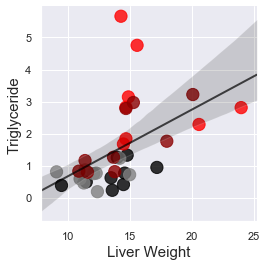

<Figure size 288x288 with 0 Axes>

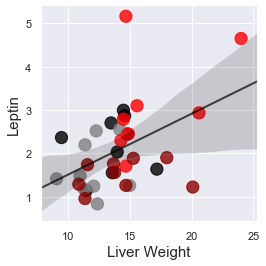

In [10]:
colors= []
for row in anova_data['diet_and_schedule']:
    if (row == 'control ad lib'):
        colors.append('black')
    elif (row == 'control restriction'):
        colors.append('gray')
    elif (row == 'HFHS ad lib'):
        colors.append('red')
    else:
        colors.append('darkred')
    

plt.figure(figsize=(4,4))
sns.lmplot(x='liver_weight',y='Triglyceride', data= anova_data, line_kws={"alpha":0.7, "lw":2, 'color':"black"},scatter_kws={'color':colors,'s':150}, legend=True, size=3.75, aspect=1)
#plt.tick_params(labelsize=12)
plt.xlabel('Liver Weight',fontsize=15)
plt.ylabel('Triglyceride', fontsize=15)
print(stats.pearsonr(anova_data['liver_weight'], anova_data['Triglyceride']))

plt.figure(figsize=(4,4))
sns.lmplot(x='liver_weight',y='Leptin', data= anova_data, line_kws={"alpha":0.7, "lw":2, 'color':"black"},scatter_kws={'color':colors,'s':150}, legend=True, size=3.75, aspect=1)
#plt.tick_params(labelsize=12)
plt.xlabel('Liver Weight',fontsize=15)
plt.ylabel('Leptin', fontsize=15)
print(stats.pearsonr(anova_data['liver_weight'], anova_data['Leptin']))


# Comparisions of Normalized Liver Weights

In [17]:
group1 = (anova_data.where(anova_data.diet_and_schedule == "control ad lib")["liver_weight"].dropna())/(anova_data.where(anova_data.diet_and_schedule == "control ad lib")["final_BW"].dropna())
group2 = (anova_data.where(anova_data.diet_and_schedule == "control restriction")["liver_weight"].dropna())/(anova_data.where(anova_data.diet_and_schedule == "control restriction")["final_BW"].dropna())
group3 = (anova_data.where(anova_data.diet_and_schedule == "HFHS ad lib")["liver_weight"].dropna())/(anova_data.where(anova_data.diet_and_schedule == "HFHS ad lib")["final_BW"].dropna())
group4 = (anova_data.where(anova_data.diet_and_schedule == "HFHS restriction")["liver_weight"].dropna())/(anova_data.where(anova_data.diet_and_schedule == "HFHS restriction")["final_BW"].dropna())

t_test_results = {}
# Control AdLib vs Control Restricted
t_test_results["- Control AdLib vs Control Restricted"] = stats.ttest_ind(group1,group2)
# Control Adlib vs HFHS Ad Lib
t_test_results["- Control Adlib vs HFHS Ad Lib"] = stats.ttest_ind(group1,group3)
# HFHS AdLib vs HFHS Restricted
t_test_results["- HFHS AdLib vs HFHS Restricted"] = stats.ttest_ind(group3,group4)
# Control Restricted vs HFHS Restricted
t_test_results["- Control Restricted vs HFHS Restricted"] = stats.ttest_ind(group2,group4)

results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df.columns = ['statistic','pvalue']
#results_df
significant_group_v2 = results_df[results_df.pvalue<0.05].drop_duplicates(subset='pvalue')
significant_group_v2


,statistic,pvalue
